# Run wind farm simulation

In [ ]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [ ]:
# import and setup site and windTurbines
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake import IEA37SimpleBastankhahGaussian

site = IEA37Site(16)
x, y = site.initial_position.T
windTurbines = IEA37_WindTurbines()

wf_model = IEA37SimpleBastankhahGaussian(site, windTurbines)

print(wf_model)

## All wind directions and wind speeds

Run the wind farm simulation by calling the wind farm model. The this call will return a `SimulationResult`

In [ ]:
# run wind farm simulation
sim_res = wf_model(x, y, # wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=None, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=None, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                  )

## SimulationResult

A `SimulationResult` is a xarray dataset with some additional methods and attributes. 
It has the coordinates

- `wt`: Wind turbine number
- `wd`: Ambient reference wind direction
- `ws`: Ambient reference wind speed
- `x`,`y`,`h`: position and hub height of wind turbines

and data variables:

- `WD`: Local free-stream wind direction
- `WS`: Local free-stream wind speed
- `TI`: Local free-stream turbulence intensity
- `P`: Probability of flow case (wind direction and wind speed)
- `WS_eff`: Effetive local wind speed [m/s]
- `TI_eff`: Effective local turbulence intensity
- `power`: Effective power production [W]
- `ct`: Thrust coefficient
- `Yaw`: Yaw misalignment [deg]

where "effective" means "including wake effects"
 

In [ ]:
sim_res

Data can be selected using the xarray `sel` method, e.g. the power production of wind turbine 3 when the wind is coming from the East (90deg) is 2.634MW:

In [ ]:
sim_res.Power.sel(wt=3, wd=0)

Data can be plotted using the xarray `plot` method, e.g. the power production of wind turbine 0 as a function of wind direction

In [ ]:
sim_res.Power.sel(wt=0).plot()

### AEP calculation

Furthermore, `SimulationResult`, contains a method, `aep` that calculates the Annual Energy Production

In [ ]:
sim_res.aep()

The total wind farm AEP is obtained using the `sum` method

In [ ]:
sim_res.aep().sum()

The `aep` method take an optional input, `with_wake_loss` (default is True), which can be used to e.g. calculate the wake loss of the wind farm

In [ ]:
aep_with_wake_loss = sim_res.aep().sum().data
aep_witout_wake_loss = sim_res.aep(with_wake_loss=False).sum().data
(aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss

## Time series

Text(0.5, 0, 'Time [day]')

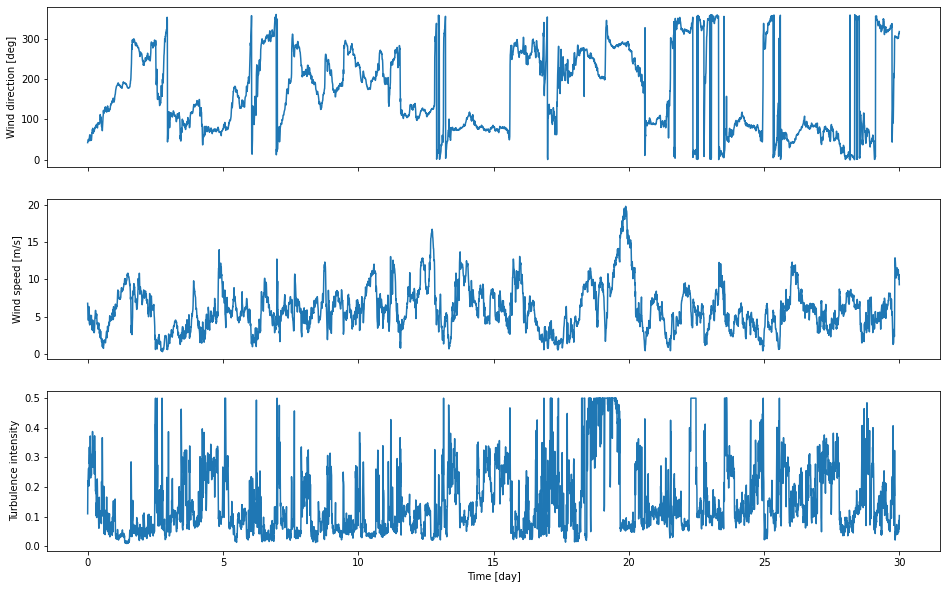

In [50]:
from py_wake.tests.test_files import tfp
d = np.load(tfp + "time.npz")
n_days=30
wd, ws, ws_std = [d[k][:6*24*n_days] for k in ['wd', 'ws', 'ws_std']]
ti = np.minimum(ws_std/ws,.5)
t = np.arange(len(wd))/6/24
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]
for ax, (v,l) in zip(axes, [(wd, 'Wind direction [deg]'),(ws,'Wind speed [m/s]'),(ti,'Turbulence intensity')]):
    ax.plot(t, v)
    ax.set_ylabel(l)
ax.set_xlabel('Time [day]')



In [51]:
# run wind farm simulation
sim_res_time = wf_model(x, y, # wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=wd, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=ws, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                   time=t
                  )

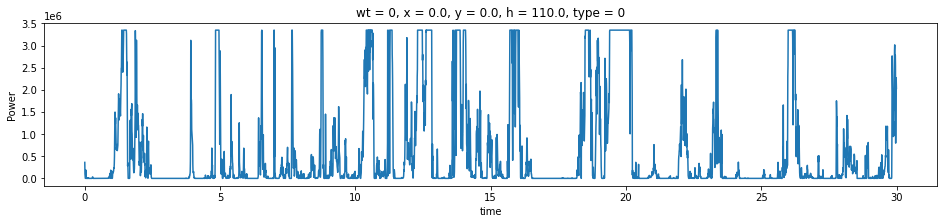

In [61]:
sim_res_time.Power.sel(wt=0).plot(figsize=(16,3))

## Flow map

Finally, `SimulationResult` has a `flow_map` method which returns a `FlowMap` object

In [ ]:
flow_map = sim_res.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
                            wd=270, 
                            ws=None)

### plot_wake_map

In [ ]:
flow_map.plot_wake_map()

In [ ]:
flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
                       cmap='jet', # color map
                       plot_colorbar=False, 
                       plot_windturbines=False, 
                       ax=None)
plt.axis('equal')

#### Grid

The grid argument should be either 

- a `HorizontalGrid`(same as `XYGrid`), `YZGrid` or 
- a tuple(X, Y, x, y, h) where X, Y is the meshgrid for visualizing the data and x, y, h are the flattened grid points

 
##### HorizontalGrid (XYGrid)


In [ ]:
from py_wake import HorizontalGrid
for grid in [None, # defaults to HorizontalGrid(resolution=500, extend=0.2)
             HorizontalGrid(x=None, y=None, resolution=100, extend=1), # custom resolution and extend
             HorizontalGrid(x = np.arange(-1000,1000,100),
                            y = np.arange(-500,500,100)) # custom x and y
            ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=None).plot_wake_map()

##### YZGrid
Vertical grid in the YZ plane

In [ ]:
from py_wake import YZGrid
for grid in [YZGrid(x=-100, y=None, resolution=100, extend=.1), # custom resolution and extend
             ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=None).plot_wake_map()